<a href="https://colab.research.google.com/github/danielabebe1/NaturalLanguageProcessing/blob/master/Identify_Fake_and_True_News_(NLP).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NLP Using naive bayes

### Identify Fake and True News

According to wikipidea, fake news, also known as junk news, pseudo-news, alternative facts or hoax news, is a form of news consisting of deliberate disinformation or hoaxes spread via traditional news media (print and broadcast) or online social media. Fake news is written and published usually with the intent to mislead in order to damage an agency, entity, or person, and/or gain financially or politically, often using sensationalist, dishonest, or outright fabricated headlines to increase readership. 

Studies lead by Data Scientist at MIT, Soroush Vosoughi shows that “It seems to be pretty clear that false information outperforms true information, And that is not just because of bots. It might have something to do with human nature.” 
The problem of fake news is not only make people to believe things but also it makes them less likely to consume correct information.

In [1]:
#import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
import re
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from sklearn.naive_bayes import GaussianNB

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
#loading dataset 
from google.colab import files
import io
uploaded = files.upload()
fake= pd.read_csv(io.BytesIO(uploaded['Fake.csv']))

Saving Fake.csv to Fake (1).csv


In [9]:
#loading dataset 
upload = files.upload()
true=pd.read_csv(io.BytesIO(upload['True.csv']))

Saving True.csv to True (2).csv


In [10]:
#display top 5 rows of fake data
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [11]:
#display top 5 rows of true data
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [12]:
#add target for both data
fake['target']=0
true['target']=1

In [13]:
#Merging the 2 datasets
df = pd.concat([true,fake]) 

In [14]:
#merging title and text columns and drop 
df['text'] = df['text'] + " " + df['title']
df=df.drop(['title'], axis=1)
df=df.drop(['date'], axis=1)

In [15]:
df.to_pickle("dataset.pkl")

In [16]:
#check missing values
df.isnull().sum()

text       0
subject    0
target     0
dtype: int64

In [17]:

df.describe(include='all')

,text,subject,target
count,44898,44898,44898.000000
unique,39105,8,NaN
top,(Reuters) - Highlights for U.S. President Dona...,politicsNews,NaN
freq,8,11272,NaN
mean,NaN,NaN,0.477015
std,NaN,NaN,0.499477
min,NaN,NaN,0.000000
25%,NaN,NaN,0.000000
50%,NaN,NaN,0.000000
75%,NaN,NaN,1.000000


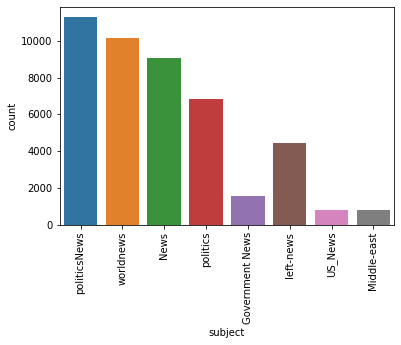

In [18]:
sns.countplot(df.subject)
plt.xticks(rotation=90)
plt.show()

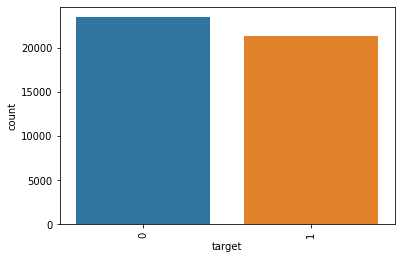

In [19]:
sns.countplot(df.target)
plt.xticks(rotation=90)
plt.show()

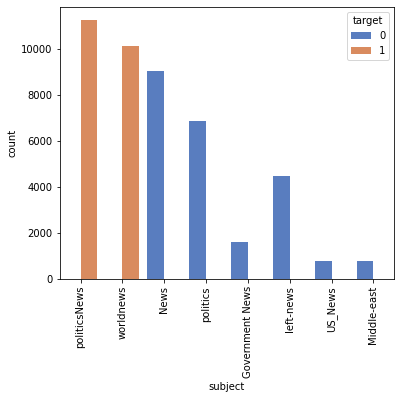

In [20]:
plt.figure(figsize = (6,5))
sns.countplot(x = "subject", hue = "target" , data = df , palette = 'muted')
plt.xticks(rotation=90)
plt.show()

##Cleaning the texts

In [21]:
# Apply a first round of text cleaning techniques
#Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.
def clean_text1(text):
    
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = re.sub('https?://\S+|www.\S+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

round1 = lambda x: clean_text1(x)

In [22]:
data_clean = pd.DataFrame(df.text.apply(round1))

In [23]:
data_clean.head()

,text
0,washington reuters the head of a conservat...
1,washington reuters transgender people will...
2,washington reuters the special counsel inv...
3,washington reuters trump campaign adviser ...
4,seattle washington reuters president donal...


In [24]:
#looking at the text, the stopwords are not yet removed, hence we need second round cleaning 
nltk.download('stopwords')
from nltk.corpus import stopwords
def clean_text2(text):
    text = text.lower()
    text = text.split()
    ps = PorterStemmer()
    text = [ps.stem(word) for word in text if not word in set(stopwords.words('english'))]
    text = ' '.join(text)
    return text

round2 = lambda x: clean_text2(x) 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [25]:
data_clean = pd.DataFrame(df.text.apply(round2))

In [26]:
data_clean.head()

,text
0,washington (reuters) - head conserv republican...
1,washington (reuters) - transgend peopl allow f...
2,washington (reuters) - special counsel investi...
3,washington (reuters) - trump campaign advis ge...
4,seattle/washington (reuters) - presid donald t...


In [27]:
df_cleaned=pd.concat([data_clean, df['target']], axis=1)
df_cleaned.head()

,text,target
0,washington (reuters) - head conserv republican...,1
1,washington (reuters) - transgend peopl allow f...,1
2,washington (reuters) - special counsel investi...,1
3,washington (reuters) - trump campaign advis ge...,1
4,seattle/washington (reuters) - presid donald t...,1


In [29]:
# Let's pickle it for later use
df_cleaned.to_pickle("clean.pkl")

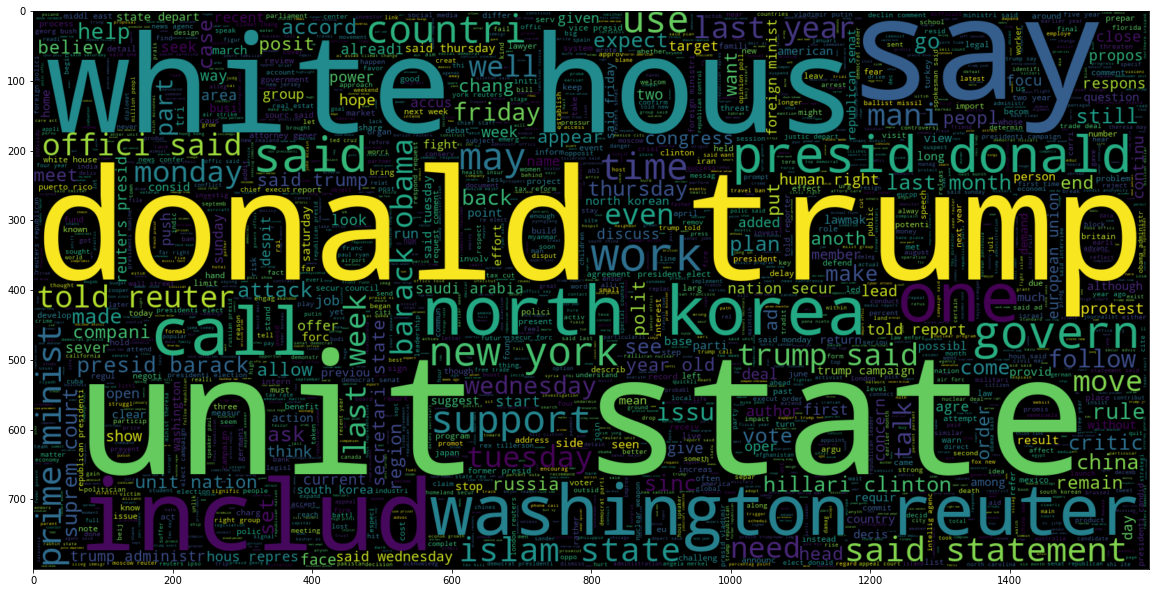

In [ ]:
# Text that is not Fake
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df_cleaned[df_cleaned.target == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

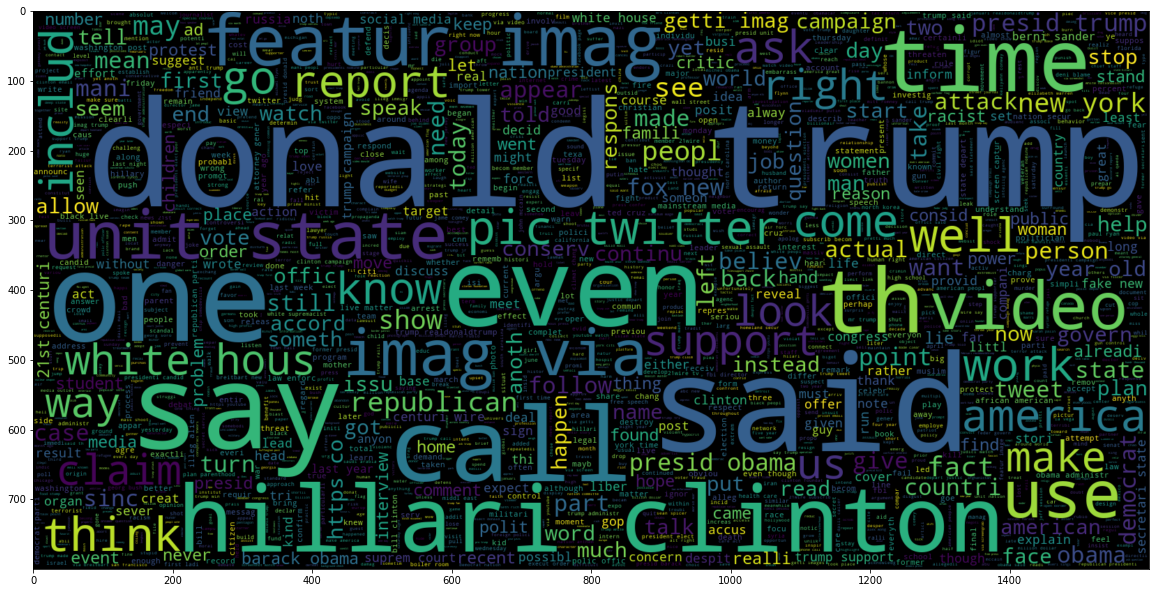

In [ ]:
# Text that is Fake
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df_cleaned[df_cleaned.target == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

In [2]:
from google.colab import files
import io
uploaded = files.upload()
df= pd.read_pickle(io.BytesIO(uploaded['clean.pkl']))

Saving clean.pkl to clean (2).pkl


In [3]:
# We are going to create a document-term matrix using CountVectorizer, by limiting the number of features
cv = CountVectorizer(max_features = 10000)
X = cv.fit_transform(df.text).toarray()
y = df.iloc[:, 1].values

In [6]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [7]:
#Training the Naive Bayes model on the Training set
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [8]:
#Predicting the Test set results
y_pred = classifier.predict(X_test)

In [9]:
#Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[4274  396]
 [ 351 3959]]


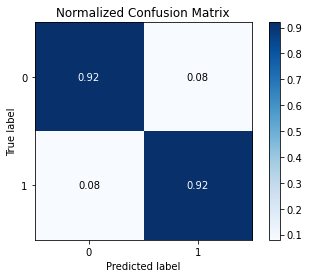

In [13]:

#normilized confusion matrix!pip install scikit-plot
import scikitplot as skplt 
import matplotlib.pyplot as plt
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)

In [10]:
#Making the accuracy_score
ac = accuracy_score(y_test, y_pred)
print(ac)

0.916815144766147
